In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/amiratag/DataShapley.git

Cloning into 'DataShapley'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 79 (delta 0), reused 2 (delta 0), pack-reused 76
Unpacking objects: 100% (79/79), done.


In [ ]:
import os
os.chdir("DataShapley")

In [ ]:


from DShap import DShap
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from Shapley import ShapNN

from shap_utils import *
%matplotlib inline
import sys
import time
import numpy as np
from Shapley import ShapNN
from DShap import DShap
import matplotlib.pyplot as plt
import sklearn
from shap_utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import sklearn.ensemble
import random
from math import ceil

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
df = pd.read_csv('/gdrive/My Drive/CICIDS2017/dataset/cicids2017_merge.csv')

####Dataset info



In [ ]:
df.shape

(2827876, 71)

In [ ]:
df['Label'].value_counts()[0]

2271320

In [ ]:
df['Label'].value_counts().index

Index(['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye',
       'FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest',
       'Bot', 'Web Attack Brute Force', 'Web Attack XSS', 'Infiltration',
       'Web Attack Sql Injection', 'Heartbleed'],
      dtype='object')

In [ ]:
label_list = ['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'Other attacks']
size = list(df['Label'].value_counts())[0:4] + [sum(list(df['Label'].value_counts())[4:])]
#color = ["red", "green", "blue"]

plt.figure(figsize=(10, 10))
plt.pie(size, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")    # 设置横轴和纵轴大小相等，这样饼才是圆的
plt.legend()
plt.show()

In [ ]:
df.columns.values

####preprocessing

In [ ]:
df.columns[~(df != 0).any(axis=0)]
df = df.loc[:, (df != 0).any(axis=0)]
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

NameError: ignored

In [ ]:
df.shape

####select feautures

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [ ]:
selected_label = ['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye',
       'FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest',
       'Bot', 'Web Attack Brute Force', 'Web Attack XSS', 'Infiltration',
       'Web Attack Sql Injection', 'Heartbleed']
df_num = 2000


In [ ]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

In [ ]:
['Packet Length Std' , 'Avg Bwd Segment Size', 'Bwd Packet Length Std', 'Bwd Packet Length Mean',
 'Destination Port', 'Average Packet Size', 'Packet Length Variance', 'Bwd Packet Length Max',
 'Fwd Packet Length Max', 'Max Packet Length', 'Init_Win_bytes_forward','Packet Length Mean',
 'Subflow Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Avg Fwd Segment Size']

In [ ]:
seed = 1
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
df

,Packet Length Std,Destination Port,Fwd Packet Length Max,Init_Win_bytes_forward,Subflow Fwd Packets,Fwd Packet Length Mean,Total Length of Fwd Packets,Avg Fwd Segment Size,Label
0,0.000000,54865,6,33,2,6.0,12,6.0,BENIGN
1,0.000000,55054,6,29,1,6.0,6,6.0,BENIGN
2,0.000000,55055,6,29,1,6.0,6,6.0,BENIGN
3,0.000000,46236,6,31,1,6.0,6,6.0,BENIGN
4,0.000000,54863,6,32,2,6.0,12,6.0,BENIGN
...,...,...,...,...,...,...,...,...,...
2830738,23.421602,53,28,-1,4,28.0,112,28.0,BENIGN
2830739,76.133435,53,42,-1,2,42.0,84,42.0,BENIGN
2830740,16.350331,58030,31,1006,2,15.5,31,15.5,BENIGN
2830741,42.332021,53,32,-1,6,32.0,192,32.0,BENIGN


In [ ]:
df['Label'].value_counts()

BENIGN                      2271320
DoS Hulk                     230124
PortScan                     158804
DDoS                         128025
DoS GoldenEye                 10293
FTP-Patator                    7935
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1956
Web Attack Brute Force         1507
Web Attack XSS                  652
Infiltration                     36
Web Attack Sql Injection         21
Heartbleed                       11
Name: Label, dtype: int64

In [ ]:
#for i in range(len(selected_label)):
df = pd.concat([df[df['Label'] == selected_label[i]][:int(df_num*df['Label'].value_counts()[i]/df.shape[0])] for i in range(len(selected_label))])
#df = pd.concat([df[df['Label'] == selected_label[0]][:df_num], df[df['Label'] == selected_label[1]][:df_num]])

#####robust

In [ ]:
train_set, test_set = train_test_split(df, test_size=0.3, random_state=seed)
train_X = train_set.drop('Label', axis=1)
train_y = train_set[['Label']]
test_X = test_set.drop('Label', axis=1)
test_y = test_set[['Label']]

#Scaler = StandardScaler()
Scaler = MinMaxScaler()
train_X = Scaler.fit_transform(train_X)
test_X = Scaler.transform(test_X)

encode = LabelEncoder()
test_y = encode.fit_transform(test_y)
train_y = encode.fit_transform(train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def nwrate(a, b, c, d, wrate):
  for i in random.sample(list(np.arange(0,len(c))), int(len(c) * wrate)):
    c[i] = abs(c[i] - 1)
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

In [ ]:
acc_result = []
s = time.time()
for i in range(0, 105, 5):
  c = train_y.copy()
  acc_result.append(nwrate(train_X, test_X, c, test_y, i/100))
print(time.time() - s)

878.0175371170044


In [ ]:
acc_result

[0.9998666666666667,
 0.9952833333333333,
 0.9876833333333334,
 0.97145,
 0.9492333333333334,
 0.9176333333333333,
 0.86315,
 0.7973833333333333,
 0.7205166666666667,
 0.6181333333333333,
 0.50595,
 0.3902833333333333,
 0.28476666666666667,
 0.20216666666666666,
 0.13451666666666667,
 0.08686666666666666,
 0.052816666666666665,
 0.029433333333333332,
 0.013683333333333334,
 0.0052833333333333335,
 0.00013333333333333334]

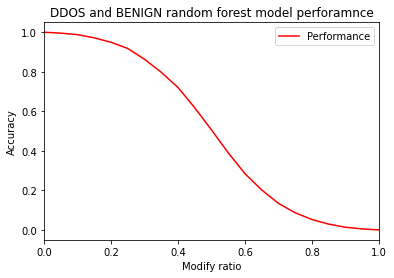

In [ ]:
plt.plot([i/100 for i in range(0, 105, 5)], acc_result, 'r', label='Performance')

plt.xlim(0, 1)
plt.title('DDOS and BENIGN random forest model perforamnce')
plt.xlabel('Modify ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(np.array(acc_result).reshape(-1, 1), [i/100 for i in range(0, 105, 5)])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
result = regressor.predict(np.array(0.978).reshape(-1,1))
result

array([0.15])

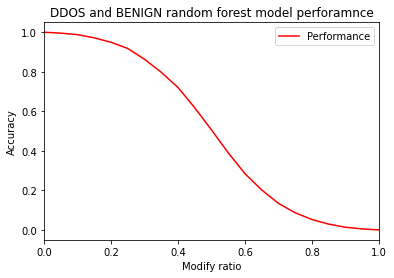

In [ ]:
plt.plot([i/100 for i in range(0, 105, 5)], result, 'r', label='Performance')

plt.xlim(0, 1)
plt.title('DDOS and BENIGN random forest model perforamnce')
plt.xlabel('Modify ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(acc_result, result, squared=False)
rms

0.0

#####importance

In [ ]:
train_set, test_set = train_test_split(df, test_size=0.3, random_state=1)
train_X = train_set.drop('Label', axis=1)
train_y = train_set[['Label']]
test_X = test_set.drop('Label', axis=1)
test_y = test_set[['Label']]

#Scaler = StandardScaler()
Scaler = MinMaxScaler()
train_X = Scaler.fit_transform(train_X)
test_X = Scaler.transform(test_X)

encode = LabelEncoder()
test_y = encode.fit_transform(test_y)
train_y = encode.fit_transform(train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
encode.fit_transform(selected_label)

array([ 0,  4, 10,  2,  3,  7, 11,  6,  5,  1, 12, 14,  9, 13,  8])

In [ ]:
train_set.shape

(1979513, 9)

In [ ]:
df.columns.values[:-1]

array(['Packet Length Std', 'Destination Port', 'Fwd Packet Length Max',
       'Init_Win_bytes_forward', 'Subflow Fwd Packets',
       'Fwd Packet Length Mean', 'Total Length of Fwd Packets',
       'Avg Fwd Segment Size'], dtype=object)

In [ ]:
forest_importances  = pd.Series([0]*len(df.columns.values[:-1]), index=df.columns.values[:-1])

model = RandomForestClassifier(n_estimators=50, random_state=seed)
model.fit(train_X, train_y)
forest_importances += pd.Series(model.feature_importances_, index=df.columns.values[:-1])

In [ ]:
model.feature_importances_

array([0.32142708, 0.11044745, 0.10959339, 0.15108808, 0.08795794,
       0.07955787, 0.07673987, 0.06318833])

In [ ]:
forest_importances  = pd.Series([0]*len(df.columns.values[:-1]), index=df.columns.values[:-1])
for i in range(10):
  model = RandomForestClassifier(n_estimators=50, random_state=i)
  model.fit(train_X, train_y)
  forest_importances += pd.Series(model.feature_importances_, index=df.columns.values[:-1])

NameError: ignored

In [ ]:
forest_importances = forest_importances.sort_values(ascending=False)

In [ ]:
forest_importances 

In [ ]:
fig, ax = plt.subplots()

forest_importances.plot.bar(ax=ax)
fig.tight_layout()
plt.show()

In [ ]:
selected_features = list(forest_importances.index)+['Label']
selected_features

In [ ]:
import seaborn as sns

In [ ]:
# df = df[['Avg Fwd Segment Size',
#  'Fwd Packet Length Max',
#  'Fwd Packet Length Mean',
#  'act_data_pkt_fwd',
#  'Total Fwd Packets',
#  'Total Length of Fwd Packets',
#  'Fwd Header Length.1',
#  'Subflow Fwd Packets',
#  'Fwd Header Length',
#  'Subflow Fwd Bytes',
#  'Label']]
df = df[['Packet Length Std' , 
 'Destination Port',  
 'Fwd Packet Length Max', 'Init_Win_bytes_forward',
 'Subflow Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Avg Fwd Segment Size',
 'Label']]

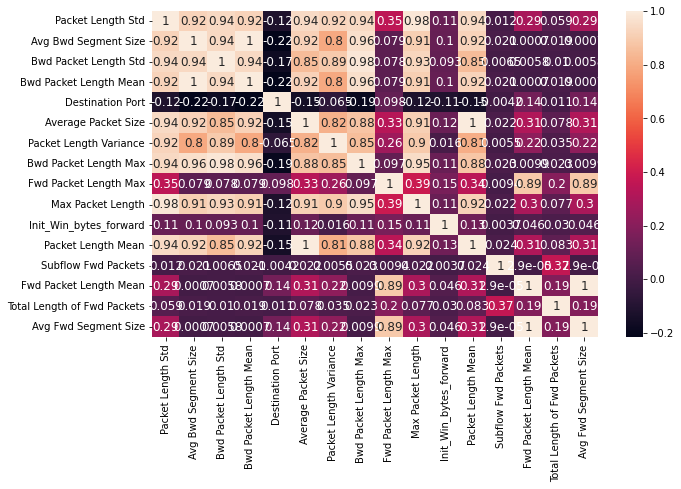

In [ ]:
corr = df.corr()
corr
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

####Evaluation


In [ ]:
import tensorflow as tf
#importing confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics
from sklearn.metrics import accuracy_score

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
]
metrics=METRICS

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:

def display_metrics(y_test, y_pred, label_names):
  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))

#

  print('\nClassification Report\n')
  print(classification_report(y_test, y_pred, target_names=label_names, digits=4))

def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

labels_d = make_value2index(df['Label']) 

In [ ]:
pd.Series(y_pred).value_counts()

0     682196
4      69508
10     47636
2      38249
3       3161
7       2345
11      1823
5       1648
6       1295
1        430
12        50
9          8
14         7
8          5
13         2
dtype: int64

In [ ]:
y_pred = model.predict(test_X)
display_metrics(test_y, y_pred, labels_d)


Accuracy: 0.9973


Classification Report

                          precision    recall  f1-score   support

                  BENIGN     0.9978    0.9990    0.9984    681389
                     Bot     0.9465    0.6993    0.8043       582
                    DDoS     0.9995    0.9991    0.9993     38264
           DoS GoldenEye     0.9699    0.9783    0.9741      3134
                DoS Hulk     0.9954    0.9986    0.9970     69288
        DoS Slowhttptest     0.9879    0.9915    0.9897      1642
           DoS slowloris     0.9969    0.7196    0.8359      1794
             FTP-Patator     1.0000    0.9962    0.9981      2354
              Heartbleed     1.0000    0.8333    0.9091         6
            Infiltration     1.0000    0.8000    0.8889        10
                PortScan     0.9935    0.9983    0.9959     47408
             SSH-Patator     1.0000    0.9989    0.9995      1825
  Web Attack Brute Force     0.9600    0.1032    0.1864       465
Web Attack Sql Injection     0.5

##DATA shapley

###sample data

In [ ]:
selected_features = ['Packet Length Std' , 
 'Destination Port',  
 'Fwd Packet Length Max', 'Init_Win_bytes_forward',
 'Subflow Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Avg Fwd Segment Size',
 'Label']
selected_label = ['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye',
       'FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest',
       'Bot', 'Web Attack Brute Force', 'Web Attack XSS', 'Infiltration',
       'Web Attack Sql Injection', 'Heartbleed']
df_num = 4000
df = df[selected_features]

In [ ]:
df['Label'].value_counts()

BENIGN                      2271320
DoS Hulk                     230124
PortScan                     158804
DDoS                         128025
DoS GoldenEye                 10293
FTP-Patator                    7935
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1956
Web Attack Brute Force         1507
Web Attack XSS                  652
Infiltration                     36
Web Attack Sql Injection         21
Heartbleed                       11
Name: Label, dtype: int64

In [ ]:
seed = 1
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
df1 = pd.concat([df[df['Label'] == selected_label[i]][:ceil(df_num*df['Label'].value_counts()[i]/df.shape[0])] for i in range(len(selected_label)-6)] )
df2 = pd.concat([df[df['Label'] == selected_label[i]][:5] for i in range(len(selected_label)-6, len(selected_label))])
df = pd.concat([df1, df2])

In [ ]:
df['Label'].value_counts()

BENIGN                      3213
DoS Hulk                     326
PortScan                     225
DDoS                         182
DoS GoldenEye                 15
FTP-Patator                   12
SSH-Patator                    9
DoS slowloris                  9
DoS Slowhttptest               8
Web Attack Brute Force         5
Web Attack Sql Injection       5
Infiltration                   5
Heartbleed                     5
Web Attack XSS                 5
Bot                            5
Name: Label, dtype: int64

In [ ]:
df.shape

(4029, 9)

parameters

In [ ]:
trainsize = int(len(df)/2)
num_group = 1
test_size = 0.5
num_test = int(len(df)*test_size/2)
num_iteration = int(trainsize/num_group)*3

In [ ]:
# df['Label'].value_counts().index[1]
# dfb = df[df['Label'] == df['Label'].value_counts().index[0]]
# dfd = df[df['Label'] == df['Label'].value_counts().index[1]]
# df = dfb[:int(trainsize/(1-0.4)/2)].append(dfd[:int(trainsize/(1-0.4)/2)])
# df.shape

In [ ]:
seed = 1
train_set, test_set = train_test_split(df, test_size=test_size, random_state=seed)
train_X = train_set.drop('Label', axis=1)
train_y = train_set[['Label']]
test_X = test_set.drop('Label', axis=1)
test_y = test_set[['Label']]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
Scaler = StandardScaler()
train_X = Scaler.fit_transform(train_X)
test_X = Scaler.transform(test_X)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encode = LabelEncoder()

In [ ]:
test_y = encode.fit_transform(test_y)
train_y = encode.fit_transform(train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
encode.fit_transform(selected_label)

array([ 0,  4, 10,  2,  3,  7, 11,  6,  5,  1, 12, 14,  9, 13,  8])

In [ ]:
wrate = 0.2

In [ ]:
train_y

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [ ]:
#random change label
#random.seed(seed)
mislabel_index = []
for i in random.sample(list(np.arange(0,len(train_y))), int(len(train_y) * wrate)):
  mislabel_index.append(i)
  train_y[i] = abs(train_y[i] - 1)

In [ ]:
#group changed label
count = 0
#random.seed(seed)
begin = random.randint(0, int(len(train_y)*(1-wrate)))
end = begin + int(len(train_y)*wrate)
mislabel_index = [i for i in range(begin, end)]
for i in range(begin, end):
  train_y[i] = abs(train_y[i] - 1)
  count +=1 


TypeError: ignored

In [ ]:
mislabel_index 

[1, 5]

In [ ]:
def trans_wrongindex(mislabel_index, l):
  TF_index = []
  for i in range(l):
    TF_index.append(False) if i in mislabel_index else TF_index.append(True)
  return TF_index

In [ ]:
origin_mark = trans_wrongindex(mislabel_index, len(train_y))

In [ ]:
import math

In [ ]:
sources = {}

In [ ]:
for i in range(0, len(train_X), num_group):
    sources[int(i/num_group)] = np.array(list(range(i,i+num_group,1)))

In [ ]:
len(train_X)

10

In [ ]:
sources

{0: array([0]),
 1: array([1]),
 2: array([2]),
 3: array([3]),
 4: array([4]),
 5: array([5]),
 6: array([6]),
 7: array([7]),
 8: array([8]),
 9: array([9])}

In [ ]:
import time

In [ ]:
X, y = train_X, train_y
X_test, y_test = test_X, test_y
model = 'RandomForest'
problem = 'classification'
num_test = int(num_test/2)
directory = './temp'
dshap = DShap(X, y, X_test, y_test, num_test, 
              sources=sources, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
s = time.time()
dshap.run(trainsize, 0.2)
print(time.time() - s)


Starting LOO score calculations!
LOO values calculated!
1 out of 10 TMC_Shapley iterations.
[2 8 4 9 1 6 7 3 0 5]
2 out of 10 TMC_Shapley iterations.
[3 5 1 2 9 8 0 6 7 4]
3 out of 10 TMC_Shapley iterations.
[2 3 8 4 5 1 0 6 9 7]
4 out of 10 TMC_Shapley iterations.
[6 1 9 2 7 5 8 0 3 4]
5 out of 10 TMC_Shapley iterations.
[5 2 7 4 1 0 6 8 9 3]
6 out of 10 TMC_Shapley iterations.
[1 8 9 5 2 6 3 7 4 0]
7 out of 10 TMC_Shapley iterations.
[3 2 1 7 8 6 5 4 9 0]
8 out of 10 TMC_Shapley iterations.
[0 9 2 3 5 6 7 1 8 4]
9 out of 10 TMC_Shapley iterations.
[7 8 9 1 4 5 3 6 0 2]
10 out of 10 TMC_Shapley iterations.
[1 2 5 0 8 3 7 9 6 4]
1 out of 10 TMC_Shapley iterations.
[9 7 8 1 0 6 5 2 3 4]
2 out of 10 TMC_Shapley iterations.
[4 9 6 2 1 8 5 7 0 3]
3 out of 10 TMC_Shapley iterations.
[4 6 1 8 9 5 7 2 3 0]
4 out of 10 TMC_Shapley iterations.
[5 9 4 1 6 7 8 3 2 0]
5 out of 10 TMC_Shapley iterations.
[0 5 7 1 4 8 6 2 9 3]
6 out of 10 TMC_Shapley iterations.
[7 8 6 5 0 3 2 4 1 9]
7 out of 10 TM

In [ ]:
dshap.merge_results()

./temp/mem_tmc_0000.pkl


In [ ]:
dshap.vals_tmc

array([-0.12142857, -0.07857143, -0.12857143, -0.10714286,  0.        ,
        0.        ,  0.        , -0.10714286, -0.08571429,  0.        ])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def detect_F(y_t, y_p):
  i = 0
  detect = 0
  nodetect = 0
  wp = 0
  dd = 0
  for i in range(len(y_t)):
    if y_t[i] == False:
      if y_p[i] == False:
        detect += 1
      else:
        nodetect += 1
    if y_t[i] == True:
      if y_p[i] == False:
        wp += 1
      else:
        dd += 1
  return detect,nodetect,wp,dd

In [ ]:
def detection_rate(vals, origin_mark, f, z=False):
  """input: dshap.vals_tmc, dshap.sources, frak"""
  sort_index = np.argsort(vals)
  if z == False:
    p_wrong = sort_index[:int(f*len(sort_index))]  
  else:
    p_wrong = []
    for i in range(len(vals)):
      if vals[i] < 0:
        p_wrong.append(i)
  mark_pre = trans_wrongindex(p_wrong, len(sort_index))
  return detect_F(origin_mark, mark_pre)

In [ ]:
print( detection_rate(list(dshap.vals_tmc), origin_mark=origin_mark, f=0.4,z=True))

(1, 1, 5, 3)


In [ ]:
dshap.vals_tmc

array([-0.12142857, -0.07857143, -0.12857143, -0.10714286,  0.        ,
        0.        ,  0.        , -0.10714286, -0.08571429,  0.        ])

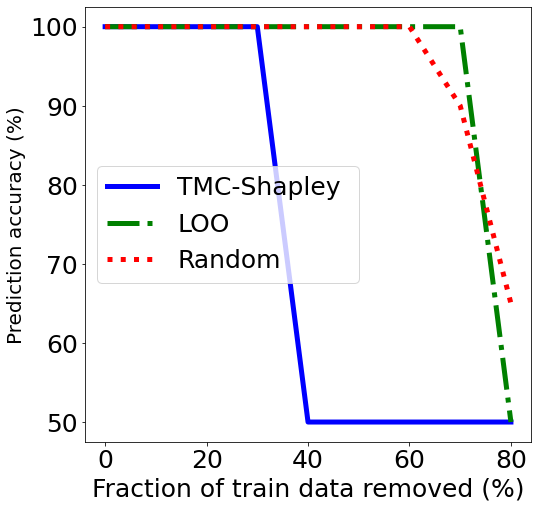

In [ ]:
dshap.performance_plots([dshap.vals_tmc, dshap.vals_loo], num_plot_markers=200,sources=dshap.sources)

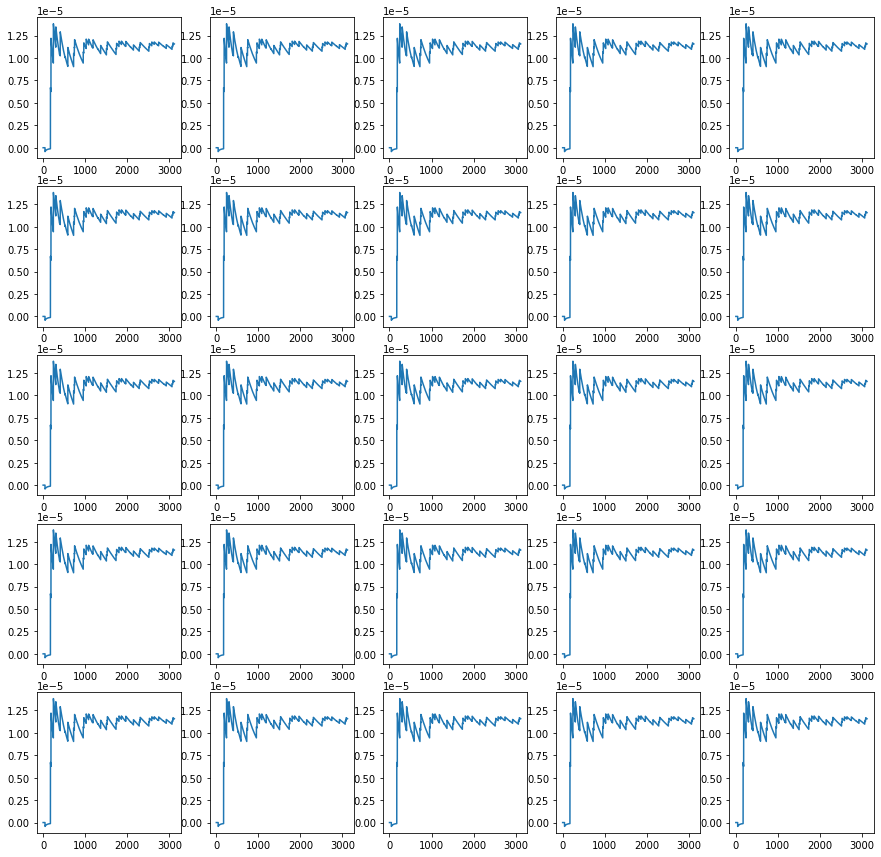

In [ ]:
convergence_plots(dshap.marginals_tmc)

In [ ]:
len(dshap.marginals_tmc)

300

#####type 2 attack

In [ ]:
#reload dataset
df = pd.read_csv('/gdrive/My Drive/CICIDS2017/dataset/cicids2017_merge.csv')
df.columns[~(df != 0).any(axis=0)]
df = df.loc[:, (df != 0).any(axis=0)]
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

selected_features = ['Packet Length Std' , 
 'Destination Port',  
 'Fwd Packet Length Max', 'Init_Win_bytes_forward',
 'Subflow Fwd Packets', 'Fwd Packet Length Mean', 'Total Length of Fwd Packets', 'Avg Fwd Segment Size',
 'Label']
selected_label = ['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS', 'DoS GoldenEye',
       'FTP-Patator', 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest',
       'Bot', 'Web Attack Brute Force', 'Web Attack XSS', 'Infiltration',
       'Web Attack Sql Injection', 'Heartbleed']
df_num = 4000
df = df[selected_features]

seed = 1
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

df1 = pd.concat([df[df['Label'] == selected_label[i]][:ceil(df_num*df['Label'].value_counts()[i]/df.shape[0])] for i in range(len(selected_label)-6)] )
df2 = pd.concat([df[df['Label'] == selected_label[i]][:5] for i in range(len(selected_label)-6, len(selected_label))])
df = pd.concat([df1, df2])

trainsize = int(len(df)/2)

test_size = 0.5
num_test = int(len(df)*test_size/2)


train_set, test_set = train_test_split(df, test_size=test_size, random_state=seed)
train_X = train_set.drop('Label', axis=1)
train_y = train_set[['Label']]
test_X = test_set.drop('Label', axis=1)
test_y = test_set[['Label']]

Scaler = StandardScaler()
train_X = Scaler.fit_transform(train_X)
test_X = Scaler.transform(test_X)

encode = LabelEncoder()

test_y = encode.fit_transform(test_y)
train_y = encode.fit_transform(train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
encode.fit_transform(selected_label)

array([ 0,  4, 10,  2,  3,  7, 11,  6,  5,  1, 12, 14,  9, 13,  8])

In [ ]:
def trans_wrongindex(mislabel_index, l):
  TF_index = []
  for i in range(l):
    TF_index.append(False) if i in mislabel_index else TF_index.append(True)
  return TF_index

In [ ]:
def detect_F(y_t, y_p):
  i = 0
  detect = 0
  nodetect = 0
  wp = 0
  dd = 0
  for i in range(len(y_t)):
    if y_t[i] == False:
      if y_p[i] == False:
        detect += 1
      else:
        nodetect += 1
    if y_t[i] == True:
      if y_p[i] == False:
        wp += 1
      else:
        dd += 1
  return detect,nodetect,wp,dd

In [ ]:
def detection_rate(vals, origin_mark, f, z=False):
  """input: dshap.vals_tmc, dshap.sources, frak"""
  sort_index = np.argsort(vals)
  if z == False:
    p_wrong = sort_index[:int(f*len(sort_index))]  
  else:
    p_wrong = []
    for i in range(len(vals)):
      if vals[i] < 0:
        p_wrong.append(i)
  mark_pre = trans_wrongindex(p_wrong, len(sort_index))
  return detect_F(origin_mark, mark_pre)

In [ ]:
len(train_X)

2014

######modify 1 random

区间 random modify

In [ ]:
def mod_label_random(i):
  t = random.randint(0, 14)
  if t != i:
    return t
  else:
    return mod_label_random(i)

In [ ]:
wrate = 0.2
count = 0
random.seed(seed)
begin = random.randint(0, int(len(train_y)*(1-wrate)))
end = begin + int(len(train_y)*wrate)
mislabel_index = [i for i in range(begin, end)]
for i in range(begin, end):
  train_y[i] = mod_label_random(train_y[i])
  count +=1 

In [ ]:
def nwrate_1(a, b, c, d, wrate):
  c = train_y.copy()
  count = 0
  random.seed(seed)
  begin = random.randint(0, int(len(c)*(1-wrate)))
  end = begin + int(len(c)*wrate)
  mislabel_index = [i for i in range(begin, end)]
  for i in range(begin, end):
    c[i] = mod_label_random(c[i])
    count +=1 
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

######modify 2 attack to benign

区间 modify all attack to benign

In [ ]:
wrate = 0.2
count = 0
random.seed(seed)
begin = random.randint(0, int(len(train_y)*(1-wrate)))
end = begin + int(len(train_y)*wrate)
mislabel_index = [i for i in range(begin, end)]
for i in range(begin, end):
  if train_y[i] != 0:
    train_y[i] = 0
    count += 1

In [ ]:
def nwrate_2(a, b, c, d, wrate):
  c = train_y.copy()
  count = 0
  random.seed(seed)
  begin = random.randint(0, int(len(c)*(1-wrate)))
  end = begin + int(len(c)*wrate)
  mislabel_index = [i for i in range(begin, end)]
  for i in range(begin, end):
    if c[i] != 0:
      c[i] = 0
      count += 1 
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

##### modify 3 specific attack to bening

区间 modify specific to benign

In [ ]:
wrate = 0.2
#group changed label
count = 0
random.seed(seed)
begin = random.randint(0, int(len(train_y)*(1-wrate)))
end = begin + int(len(train_y)*wrate)
mislabel_index = [i for i in range(begin, end)]
specific = 4
for i in range(begin, end):
  if train_y[i] == 4:
    train_y[i] = 0
    count += 1 

In [ ]:
def nwrate_3(a, b, c, d, wrate):
  c = train_y.copy()
  count = 0
  random.seed(seed)
  begin = random.randint(0, int(len(c)*(1-wrate)))
  end = begin + int(len(c)*wrate)
  mislabel_index = [i for i in range(begin, end)]
  for i in range(begin, end):
    if c[i] == 4:
      c[i] = 0
      count += 1  
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

#####modify 4 specific attack change rate

modify wrate% specific attack to normal

In [ ]:
wrate = 0.2
#group changed label
attack_count = 0
# random.seed(seed)
# begin = random.randint(0, int(len(train_y)*(1-wrate)))
# end = begin + int(len(train_y)*wrate)
# mislabel_index = [i for i in range(begin, end)]

specific = 4
for i in train_y:
  if i == specific:
    attack_count += 1
mod_label = attack_count * warate
mislabel_index = []
for i in range(len(train_y)):
  if len(mislabel_index) >= mod_label:
    break
  if train_y[i] == specific:
    train_y[i] = 0
    mislabel_index.append(i)


In [12]:
def nwrate_4(a, b, c, d, wrate):
  c = train_y.copy()
  attack_count = 0
  count = 0
  specific = 4
  for i in c:
    if i == specific:
      attack_count += 1
  mod_label = attack_count * wrate
  mislabel_index = []
  for i in range(len(c)):
    if len(mislabel_index) >= mod_label:
      break
    if c[i] == specific:
      c[i] = 0
      mislabel_index.append(i) 
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

##### robust test

In [ ]:
def nwrate(a, b, c, d, wrate):
  
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

In [ ]:
len(train_y)

2014

In [ ]:
acc_result = []
s = time.time()
type_attack = 3
f = [nwrate_1, nwrate_2, nwrate_3]
f = f[type_attack - 1]
for i in range(0, 50, 5):
  acc_result.append(f(train_X, test_X, train_y, test_y, i/100))
print(time.time() - s)

1.507087230682373


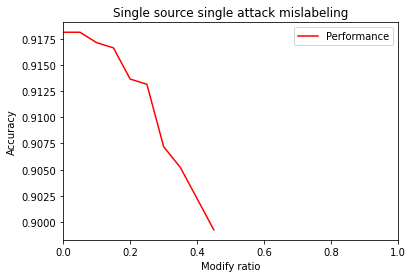

In [ ]:
plt.plot([i/100 for i in range(0, 50, 5)], acc_result, 'r', label='Performance')

plt.xlim(0, 1)
plt.title('Single source single attack mislabeling')
plt.xlabel('Modify ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
acc_result = []
s = time.time()
for i in range(0, 100, 5):
  acc_result.append(nwrate_4(train_X, test_X, train_y, test_y, i/100))
print(time.time() - s)

2.9655277729034424


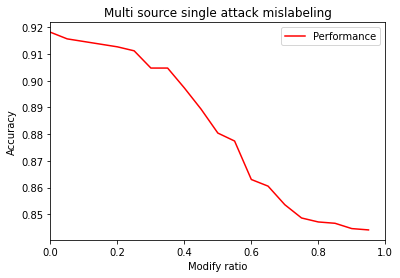

In [15]:
plt.plot([i/100 for i in range(0, 100, 5)], acc_result, 'r', label='Performance')

plt.xlim(0, 1)
plt.title('Multi source single attack mislabeling')
plt.xlabel('Modify ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### apply shapley

In [ ]:
origin_mark = trans_wrongindex(mislabel_index, len(train_y))

In [ ]:
begin

275

In [ ]:
end

677

In [ ]:
pd.Series(origin_mark).value_counts()

True     1612
False     402
dtype: int64

In [ ]:
sources = {}
group_num = 20
num_group = int(len(train_X)/group_num)
for i in range(0, len(train_X), num_group):
    sources[int(i/num_group)] = np.array(list(range(i,i+num_group,1)))
sources[int(i/num_group)] = sources[int(i/num_group)][sources[int(i/num_group)] < len(train_X)]

In [ ]:
sources

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 1: array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
        191, 192, 193, 194, 195, 

In [ ]:
num_test

1007

In [ ]:
X, y = train_X.copy(), train_y.copy()
X_test, y_test = test_X.copy(), test_y.copy()
model = 'RandomForest'
problem = 'classification'
directory = './temp'
dshap = DShap(X, y, X_test, y_test, num_test, 
              sources=sources, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
s = time.time()
dshap.run(group_num*3, 0.1)
print(time.time() - s)


Starting LOO score calculations!
LOO values calculated!
6 out of 60 TMC_Shapley iterations.
12 out of 60 TMC_Shapley iterations.
18 out of 60 TMC_Shapley iterations.
24 out of 60 TMC_Shapley iterations.
30 out of 60 TMC_Shapley iterations.
36 out of 60 TMC_Shapley iterations.
42 out of 60 TMC_Shapley iterations.
48 out of 60 TMC_Shapley iterations.
54 out of 60 TMC_Shapley iterations.
60 out of 60 TMC_Shapley iterations.
6 out of 60 TMC_Shapley iterations.
12 out of 60 TMC_Shapley iterations.
18 out of 60 TMC_Shapley iterations.
24 out of 60 TMC_Shapley iterations.
30 out of 60 TMC_Shapley iterations.
36 out of 60 TMC_Shapley iterations.
42 out of 60 TMC_Shapley iterations.
48 out of 60 TMC_Shapley iterations.
54 out of 60 TMC_Shapley iterations.
60 out of 60 TMC_Shapley iterations.
6 out of 60 TMC_Shapley iterations.
12 out of 60 TMC_Shapley iterations.
18 out of 60 TMC_Shapley iterations.
24 out of 60 TMC_Shapley iterations.
30 out of 60 TMC_Shapley iterations.
36 out of 60 TMC_Shap

In [ ]:
dshap.merge_results()

./temp/mem_tmc_0000.pkl


In [ ]:
min(dshap.vals_tmc)

0.0

In [ ]:
detect_g = []
for i in range(len(dshap.vals_tmc)):
  if dshap.vals_tmc[i]== min(dshap.vals_tmc):
    detect_g.append(i)

In [ ]:
detect_g 

[300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466

In [ ]:
sources = {}
group_num = 20
old_num_group = num_group
new_num_group = int(num_group/group_num)*2
i = 0
s_begin = 0
while True:
  if s_begin + num_group > len(train_X):
    sources[i] = np.array(list(range(s_begin, len(train_X))))
    break
  if s_begin in detect_g:
    sources[i] = np.array(list(range(s_begin, s_begin+new_num_group)))
    s_begin += new_num_group
  else:
    sources[i] = np.array(list(range(s_begin, s_begin+old_num_group)))
    s_begin += old_num_group
  i += 1
# while True:
#     if i in detect_g:
#       num_group = new_num_group 
#     else:
#       num_group = old_num_group
#     if s_begin + num_group > len(train_X):
#       sources[i] = np.array(list(range(s_begin, len(train_X))))
#       break
#     sources[i] = np.array(list(range(s_begin, s_begin+num_group)))
#     s_begin += num_group
#     i += 1
#sources[int(i/num_group)] = sources[int(i/num_group)][sources[int(i/num_group)] < len(train_X)]

In [ ]:
sources

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 1: array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
        191, 192, 193, 194, 195, 

In [ ]:
X, y = train_X.copy(), train_y.copy()
X_test, y_test = test_X.copy(), test_y.copy()
model = 'RandomForest'
problem = 'classification'
directory = './temp'
dshap = DShap(X, y, X_test, y_test, num_test, 
              sources=sources, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
s = time.time()
dshap.run(group_num*3, 0.1)
print(time.time() - s)


Starting LOO score calculations!
LOO values calculated!
6 out of 60 TMC_Shapley iterations.
12 out of 60 TMC_Shapley iterations.
18 out of 60 TMC_Shapley iterations.
24 out of 60 TMC_Shapley iterations.
30 out of 60 TMC_Shapley iterations.
36 out of 60 TMC_Shapley iterations.
42 out of 60 TMC_Shapley iterations.
48 out of 60 TMC_Shapley iterations.
54 out of 60 TMC_Shapley iterations.
60 out of 60 TMC_Shapley iterations.
6 out of 60 TMC_Shapley iterations.
12 out of 60 TMC_Shapley iterations.
18 out of 60 TMC_Shapley iterations.
24 out of 60 TMC_Shapley iterations.
30 out of 60 TMC_Shapley iterations.
36 out of 60 TMC_Shapley iterations.
42 out of 60 TMC_Shapley iterations.
48 out of 60 TMC_Shapley iterations.
54 out of 60 TMC_Shapley iterations.
60 out of 60 TMC_Shapley iterations.
6 out of 60 TMC_Shapley iterations.
12 out of 60 TMC_Shapley iterations.
18 out of 60 TMC_Shapley iterations.
24 out of 60 TMC_Shapley iterations.
30 out of 60 TMC_Shapley iterations.
36 out of 60 TMC_Shap

In [ ]:
dshap.merge_results()

./temp/mem_tmc_0000.pkl


In [ ]:
pd.Series(dshap.values_tmc).value_counts()

 0.000002    100
 0.000005    100
 0.000006    100
 0.000003    100
 0.000003    100
 0.000009    100
 0.000003    100
 0.000010    100
 0.000013    100
 0.000006    100
 0.000006    100
 0.000011    100
 0.000005    100
 0.000004    100
 0.000014    100
 0.000006    100
-0.000088     14
-0.000378     10
-0.000717     10
-0.000447     10
-0.000251     10
-0.000301     10
-0.000081     10
-0.000242     10
-0.000572     10
-0.000284     10
-0.000173     10
-0.000124     10
-0.000337     10
-0.000088     10
-0.000527     10
-0.000238     10
-0.000489     10
-0.000457     10
-0.000211     10
-0.000187     10
-0.000489     10
-0.000337     10
-0.000549     10
-0.000566     10
-0.000375     10
-0.000061     10
-0.000019     10
-0.000182     10
-0.000040     10
-0.000277     10
-0.000511     10
-0.000289     10
-0.000448     10
-0.000474     10
-0.000084     10
-0.000303     10
-0.000158     10
-0.000672     10
-0.000547     10
-0.000322     10
-0.000239     10
dtype: int64

In [ ]:
result_df = pd.Series(dshap.values_tmc)[pd.Series(dshap.values_tmc)<-0.0001]

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
result_df

300   -0.000187
301   -0.000187
302   -0.000187
303   -0.000187
304   -0.000187
305   -0.000187
306   -0.000187
307   -0.000187
308   -0.000187
309   -0.000187
310   -0.000158
311   -0.000158
312   -0.000158
313   -0.000158
314   -0.000158
315   -0.000158
316   -0.000158
317   -0.000158
318   -0.000158
319   -0.000158
320   -0.000284
321   -0.000284
322   -0.000284
323   -0.000284
324   -0.000284
325   -0.000284
326   -0.000284
327   -0.000284
328   -0.000284
329   -0.000284
330   -0.000547
331   -0.000547
332   -0.000547
333   -0.000547
334   -0.000547
335   -0.000547
336   -0.000547
337   -0.000547
338   -0.000547
339   -0.000547
340   -0.000301
341   -0.000301
342   -0.000301
343   -0.000301
344   -0.000301
345   -0.000301
346   -0.000301
347   -0.000301
348   -0.000301
349   -0.000301
350   -0.000277
351   -0.000277
352   -0.000277
353   -0.000277
354   -0.000277
355   -0.000277
356   -0.000277
357   -0.000277
358   -0.000277
359   -0.000277
370   -0.000672
371   -0.000672
372   -0

In [ ]:
t = 0
for j in mislabel_index:
  if j in list(result_df.index):
    t += 1
t

337

In [ ]:
t/len(mislabel_index)

0.8383084577114428

In [ ]:
t = 0 
for j in list(result_df.index):
  if j in mislabel_index:
      t += 1
t/len(list(result_df.index))

0.9911764705882353

In [ ]:
detect_g 

[3, 4, 5, 6]

In [ ]:
dshap.marginals_tmc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
begin

275

In [ ]:
end

675

In [ ]:
origin_mark

In [ ]:
def one_train_perfor(a,b,c,d):
  model = RandomForestClassifier(n_estimators=50, random_state=0)
  model.fit(a, c)
  pred_y = model.predict(b)
  return accuracy_score(d, pred_y)

In [ ]:
print(one_train_perfor(train_X, test_X, train_y, test_y))

0.978


In [ ]:
#according to performance, estimate ratio.
#es_ratio = 0.15
sources = {}
group_num = 15
num_group = int(len(train_X)/13)
for i in range(0, len(train_X), num_group):
    sources[int(i/num_group)] = np.array(list(range(i,i+num_group,1)))

In [ ]:
sources[int(i/num_group)] = sources[int(i/num_group)][sources[int(i/num_group)] < len(train_X)]

In [ ]:
sources

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153]),
 1: array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 

In [ ]:
#收敛最低iteration 100， 修改err 
# 50 个数据可以跑出来收敛的结果。
X, y = train_X, train_y
X_test, y_test = test_X, test_y
model = 'RandomForest'
problem = 'classification'
num_test = int(num_test/2)
directory = './temp'
dshap = DShap(X, y, X_test, y_test, num_test, 
              sources=sources, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
s = time.time()
dshap.run(int(trainsize/num_group)*3, 0.2)
print(time.time() - s)

Starting LOO score calculations!
LOO values calculated!
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
4.9836530685424805


In [ ]:
dshap.vals_tmc

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
#find most low 3 shapley group. 是否连续.
#连续的话，把数据再带入。

In [ ]:
newpd = pd.array(dshap.vals_tmc)

In [ ]:
newpd[newpd < 0]

<PandasArray>
[ -0.0008586324786324787,  -0.0008586324786324787,  -0.0008586324786324787,
  -0.0008586324786324787,  -0.0008586324786324787,  -0.0008586324786324787,
  -0.0008586324786324787,  -0.0008586324786324787,  -0.0008586324786324787,
  -0.0008586324786324787,
 ...
 -2.8803418803418806e-05, -2.8803418803418806e-05, -2.8803418803418806e-05,
 -2.8803418803418806e-05, -2.8803418803418806e-05, -2.8803418803418806e-05,
 -2.8803418803418806e-05, -2.8803418803418806e-05, -2.8803418803418806e-05,
 -2.8803418803418806e-05]
Length: 450, dtype: float64

In [ ]:
def fin(v, num_group):
  sort_index = np.argsort(v)[:num_group*3]
  return sort_index
new = fin(dshap.vals_tmc, num_group)

In [ ]:
new

array([306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
       345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
       371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
       384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396,
       397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
       410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
       436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
       449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
       462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
       475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 48

In [ ]:
new = np.sort(new)

In [ ]:
len(new)

459

In [ ]:
X2, y2 = train_X[[new]], train_y[[new]]
X_test, y_test = test_X, test_y
model = 'RandomForest'
problem = 'classification'
num_test = int(num_test/2)
directory = './temp'

sources = {}
group_num = 13
num_group = int(len(X2)/13)
for i in range(0, len(X2), num_group):
    sources[int(i/num_group)] = np.array(list(range(i,i+num_group,1)))
sources[int(i/num_group)] = sources[int(i/num_group)][sources[int(i/num_group)] < len(X2)]

dshap = DShap(X2, y2, X_test, y_test, num_test, 
              sources=sources, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
s = time.time()
dshap.run(group_num*3, 0.2)
print(time.time() - s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


Starting LOO score calculations!
LOO values calculated!
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
39 out of 39 TMC_Shapley iterations.
170.01780915260315


In [ ]:
dshap.vals_tmc

array([-0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00198511, -0.00198511, -0.00198511, -0.00198511, -0.00198511,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00229706,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00229706,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00229706,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00229706,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00229706,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00229706,
       -0.00229706, -0.00229706, -0.00229706, -0.00229706, -0.00

In [ ]:
fpd = pd.array(dshap.vals_tmc)

In [ ]:
fpd[fpd>0]

<PandasArray>
[0.0003875694198274846, 0.0003875694198274846, 0.0003875694198274846,
 0.0003875694198274846, 0.0003875694198274846, 0.0003875694198274846,
 0.0003875694198274846, 0.0003875694198274846, 0.0003875694198274846,
 0.0003875694198274846,
 ...
  0.002694080113434953,  0.002694080113434953,  0.002694080113434953,
  0.002694080113434953,  0.002694080113434953,  0.002694080113434953,
  0.005996691480562445,  0.005996691480562445,  0.005996691480562445,
  0.005996691480562445]
Length: 109, dtype: float64

In [ ]:
print(one_train_perfor(X2, test_X, y2, test_y))

0.0465


In [ ]:
print(one_train_perfor(X2, test_X, y2, test_y))